In [3]:
import torch
import matplotlib.pyplot as plt
# local
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

from datasets.import_dataset import import_dataset
from trainer import Trainer
import clamiter as ci
from utils.plotting import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')
from datasets.simulations import create_sbm

%load_ext autoreload
%autoreload 2

device = cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SBM

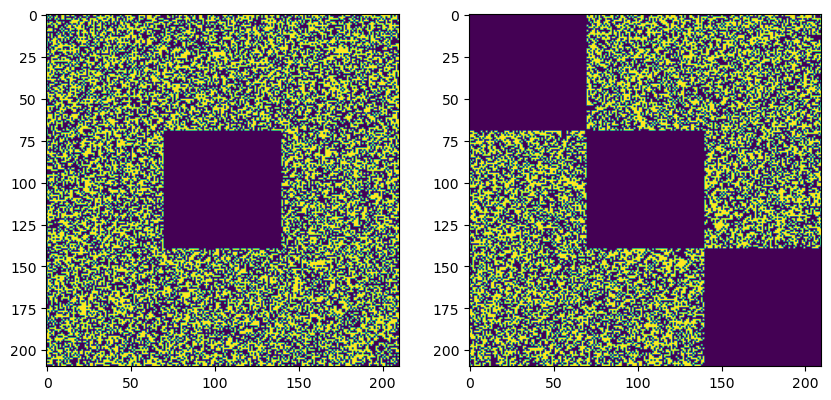

In [10]:
# import sbm and bipartite
ds_sbm_halfdiag = import_dataset('sbm3x3HalfDiag')
ds_sbm_halfcenter = import_dataset('sbm3x3HalfCenter')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# plot_adj(ds_sbm_halfcenter.edge_index, ax=axes[0])
# plot_adj(ds_sbm_halfdiag.edge_index, ax=axes[1])

# create sbm
prob_adj_3X3, y = create_sbm(70, p_comm=[0.0, 0.0, 0.0], p_bipart=[0.5, 0.5, 0.5]) 



### Lorenz Inner

#### IEClam

In [66]:
config_triplets = [
                    ['feat_opt', 'n_iter', 15000],
                    # ['feat_opt', 'lr', 0.00003],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 5],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfdiag_iegam = Trainer(
                model_name='iegam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfdiag.clone()
                
)

losses_halfdiag_iegam, logcut_halfdiag_iegam, l2_halfdiag_iegam = trainer_halfdiag_iegam.train(
    d = 0.01,
    plot_every=-1,
    init_feats=True,
    init_type='small_gaus',
    acc_every=500,
    verbose=False,
    verbose_in_funcs=False
)

# todo: move the contents of train into fit and then do trainer.clamiter.fit() not urgent. add an option for trainer to do cross validation.



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-18 21:08:14 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}


KeyboardInterrupt: 

#### PieClam

In [4]:
config_triplets = [
                    # ['feat_opt', 'n_iter', 200],
                    ['clamiter_init', 'dim_feat', 6],
                    ['feat_opt', 'lr', 0.0001],
                    # ['prior_opt', 'n_iter', 150],
                    ['prior_opt', 'lr', 0.00001],
                    ['back_forth','n_back_forth', 5],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfdiag_piegam = Trainer(
                model_name='piegam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfdiag
)

losses_halfdiag_piegam, logcut_halfdiag_piegam, l2_halfdiag_piegam = trainer_halfdiag_piegam.train(
    d = 0.2,
    plot_every=1,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False,
    node_size_factor=5,
    draw_edges=False
    
    
)
del trainer_halfdiag_piegam.data   
del trainer_halfdiag_piegam.clamiter.prior.model

NameError: name 'ds_sbm_halfdiag' is not defined

### Inner Prod

#### BIGCLAM



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:302:::  
 2024-09-03 12:28:17 starting optimization of bigclam on sbm3x3HalfDiag on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 2,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 0.01,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-05,
        "n_iter": 10000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:368:::  
fit wrapper fit_feats, plotting state at iter 9999


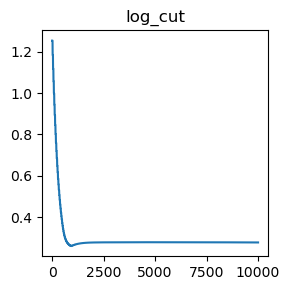

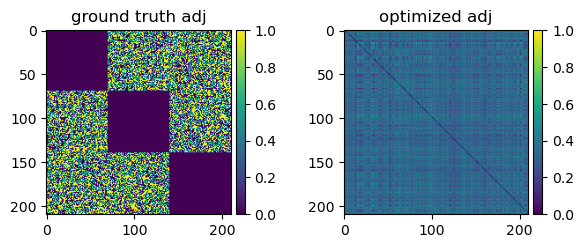

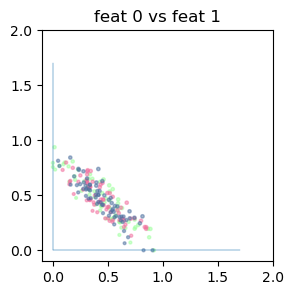



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:410:::  


FINISHED train model on params 
 last accuracies:
log_cut: 0.2773023649946192


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:416:::  





In [22]:
config_triplets = [
                    # ['feat_opt', 'n_iter', 2000],
                    # ['feat_opt', 'lr', 0.00003],
                    # ['prior_opt', 'n_iter', 1500],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 50],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfdiag_bigclam= Trainer(
                model_name='bigclam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfdiag.clone()
)

losses_halfdiag_bigclam, logcut_halfdiag_bigclam, l2_halfdiag_bigclam = trainer_halfdiag_bigclam.train(
    d = 0.2,
    plot_every=-1,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)

del trainer_halfdiag_bigclam.data

#### PClam

In [ ]:
# SBM
config_triplets = [
                    # ['feat_opt', 'n_iter', 2000],
                    # ['feat_opt', 'lr', 0.00003],
                    # ['prior_opt', 'n_iter', 1500],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 50],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfdiag_pclam = Trainer(
                model_name='pclam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfdiag.clone()
)
# i want to optimize the trainer
losses_halfdiag_pclam, logcut_halfdiag_pclam, l2_halfdiag_pclam = trainer_halfdiag_pclam.train(
    d = 0.2,
    plot_every=5,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)
del trainer_halfdiag_pclam.data
del trainer_halfdiag_pclam.clamiter.prior.model

### Lorenz Inner

#### IEClam

In [ ]:
config_triplets = [
                    # ['feat_opt', 'n_iter', 2000],
                    # ['feat_opt', 'lr', 0.00003],
                    # ['prior_opt', 'n_iter', 1500],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 50],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfdiag_iegam = Trainer(
                model_name='iegam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfdiag.clone()
)

losses_halfdiag_iegam, logcut_halfdiag_iegam, l2_halfdiag_iegam = trainer_halfdiag_iegam.train(
    d = 0.2,
    plot_every=-1,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)

del trainer_halfdiag_iegam.data


#### PieClam

In [ ]:
config_triplets = [
                    # ['feat_opt', 'n_iter', 2000],
                    # ['feat_opt', 'lr', 0.00003],
                    # ['prior_opt', 'n_iter', 1500],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 50],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfdiag_piegam = Trainer(
                model_name='piegam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfdiag.clone()
)

losses_halfdiag_piegam, logcut_halfdiag_piegam, l2_halfdiag_piegam = trainer_halfdiag_piegam.train(
    d = 0.2,
    plot_every=-1,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)

del trainer_halfdiag_piegam.data
del trainer_halfdiag_piegam.clamiter.prior.model

## HalfCenter

### Lorenz Inner

#### IEClam

In [ ]:
config_triplets = [
                    # ['feat_opt', 'n_iter', 2000],
                    # ['feat_opt', 'lr', 0.00003],
                    # ['prior_opt', 'n_iter', 1500],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 50],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfcenter_iegam = Trainer(
                model_name='iegam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfcenter.clone()
)

losses_halfcenter_iegam, logcut_halfcenter_iegam, l2_halfcenter_iegam = trainer_halfcenter_iegam.train(
    d = 0.2,
    plot_every=-1,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)
del trainer_halfcenter_iegam.data

#### PieClam



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:302:::  
 2024-09-03 12:31:21 starting optimization of piegam on sbm3x3HalfCenter on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 4,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 0.0,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 0.0001,
        "n_iter": 2000,
        "early_stop": 0
    },
    "prior_opt": {
        "n_iter": 2000,
        "lr": 1e-05,
        "noise_amp": 0.1,
        "weight_decay": 0.01,
        "early_stop": 0
    },
    "back_forth": {
        "n_back_forth": 5,
        "scheduler_step_size": 100,
        "scheduler_gamma": 0.5,
        "early_stop_fit": 0,
        "first_func_in_fit": "fit_prior"
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:546:::  
in fit,
first_func_in_fit='fit_prior'
second_function_name='fit_feats'


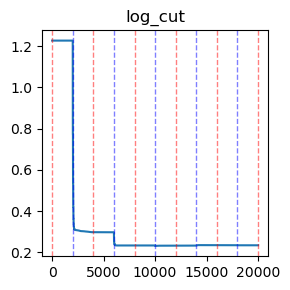

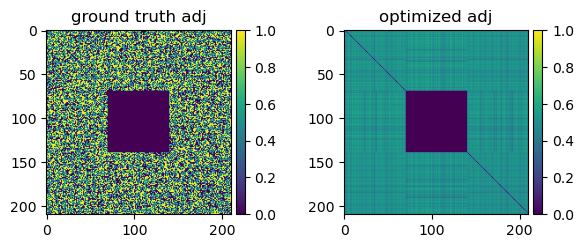

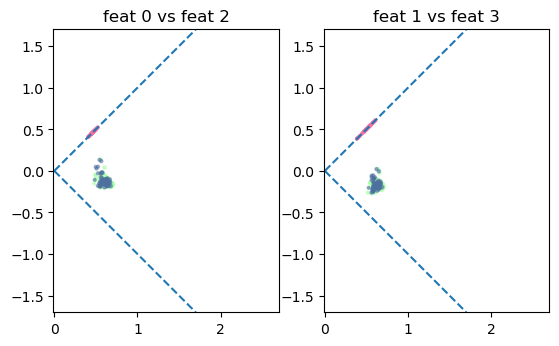



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:668:::  
fit end, no early stopping


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:410:::  


FINISHED train model on params 
 last accuracies:
log_cut: 0.23439587024206696


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:416:::  





In [23]:
config_triplets = [
                    # ['feat_opt', 'n_iter', 200],
                    ['feat_opt', 'lr', 0.0001],
                    # ['prior_opt', 'n_iter', 150],
                    ['prior_opt', 'lr', 0.00001],
                    ['back_forth','n_back_forth', 5],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfcenter_piegam = Trainer(
                model_name='piegam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfcenter.clone()
)

losses_halfcenter_piegam, logcut_halfcenter_piegam, l2_halfcenter_piegam = trainer_halfcenter_piegam.train(
    d = 0.2,
    plot_every=-1,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)
del trainer_halfcenter_piegam.data
del trainer_halfcenter_piegam.clamiter.prior.model

### Inner Prod

#### BIGCLAM



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:302:::  
 2024-09-09 12:00:23 starting optimization of bigclam on sbm3x3HalfCenter on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 2,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 0.01,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-05,
        "n_iter": 10000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:368:::  
fit wrapper fit_feats, plotting state at iter 9999


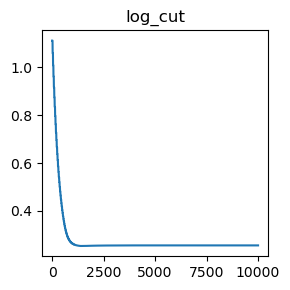

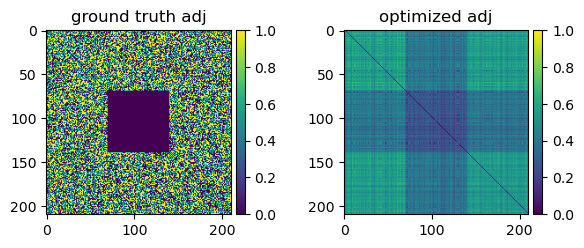

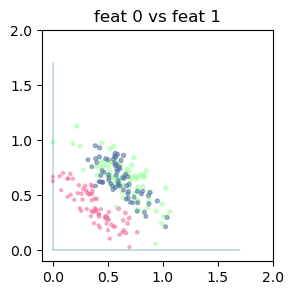



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:410:::  


FINISHED train model on params 
 last accuracies:
log_cut: 0.25566083337663514


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:416:::  





AttributeError: 'NoneType' object has no attribute 'model'

In [29]:
config_triplets = [
                    # ['feat_opt', 'n_iter', 2000],
                    # ['feat_opt', 'lr', 0.00003],
                    # ['prior_opt', 'n_iter', 1500],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 50],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfcenter_bigclam= Trainer(
                model_name='bigclam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfcenter.clone()
)

losses_halfcenter_bigclam, logcut_halfcenter_bigclam, l2_halfcenter_bigclam = trainer_halfcenter_bigclam.train(
    d = 0.2,
    plot_every=-1,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)

del trainer_halfcenter_bigclam.data
del trainer_halfcenter_bigclam.clamiter.prior.model

#### PClam

In [ ]:
# SBM
config_triplets = [
                    ['feat_opt', 'n_iter', 2000],
                    ['feat_opt', 'lr', 0.00005],
                    ['prior_opt', 'n_iter', 1500],
                    ['prior_opt', 'lr', 0.0000005],
                    ['back_forth','n_back_forth', 30],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]


trainer_halfcenter_pclam = Trainer(
                model_name='pclam',
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds_sbm_halfcenter.clone()
)
# i want to optimize the trainer
losses_halfcenter_pclam, logcut_halfcenter_pclam, l2_halfcenter_pclam = trainer_halfcenter_pclam.train(
    d = 0.2,
    plot_every=5,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)

del trainer_halfcenter_pclam.data
del trainer_halfcenter_pclam.clamiter.prior.model

# LogCut Convergence

## Find LL and LC Curve for Different d

In [115]:
import os
import torch
import matplotlib.pyplot as plt

from utils.plotting import plot_distance_experiment



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-19 02:05:07 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:372:::  
fit wrapper fit_feats, plotting state at iter 14999


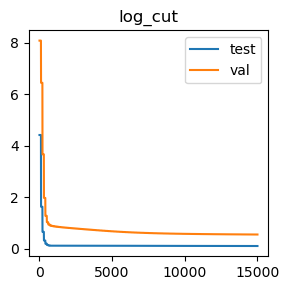

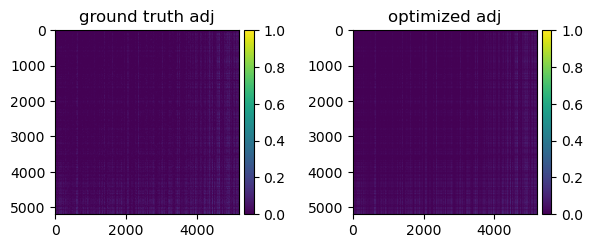



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:418:::  


FINISHED train 
 last accuracies:
test
key='log_cut': 0.1065980203370151
val
key='l2': 0.5530276894569397


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:432:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-19 02:56:08 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:372:::  
fit wrapper fit_feats, plotting state at iter 14999


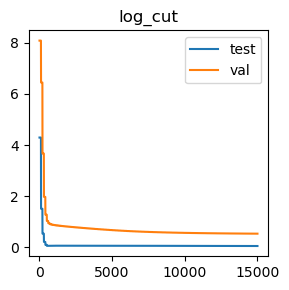

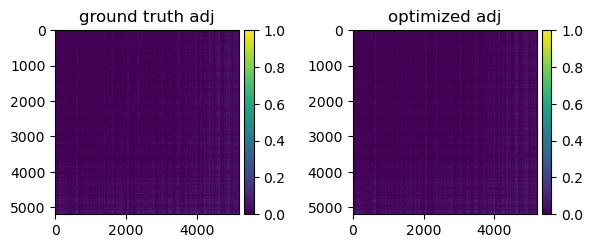



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:418:::  


FINISHED train 
 last accuracies:
test
key='log_cut': 0.049415053543636456
val
key='l2': 0.5320295095443726


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:432:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-19 03:46:40 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:372:::  
fit wrapper fit_feats, plotting state at iter 14999


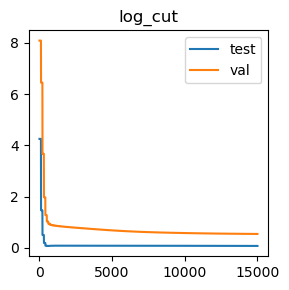

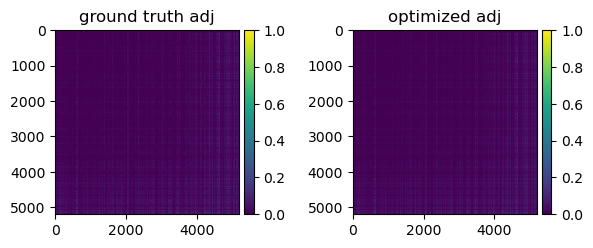



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:418:::  


FINISHED train 
 last accuracies:
test
key='log_cut': 0.0747470937390834
val
key='l2': 0.5418335199356079


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:432:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-19 04:37:35 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:372:::  
fit wrapper fit_feats, plotting state at iter 14999


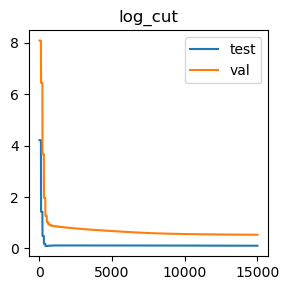

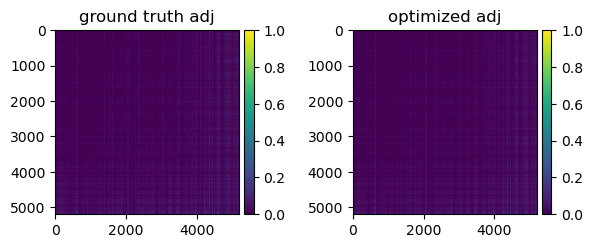



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:418:::  


FINISHED train 
 last accuracies:
test
key='log_cut': 0.10667093786623572
val
key='l2': 0.5328436493873596


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:432:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-19 05:28:42 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:372:::  
fit wrapper fit_feats, plotting state at iter 14999


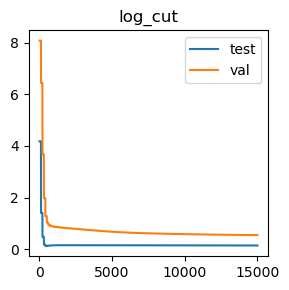

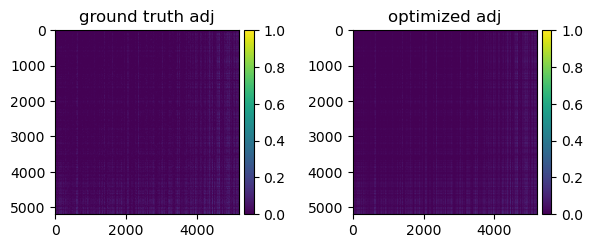



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:418:::  


FINISHED train 
 last accuracies:
test
key='log_cut': 0.14164945160323766
val
key='l2': 0.5436352491378784


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:432:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-19 06:19:49 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:372:::  
fit wrapper fit_feats, plotting state at iter 14999


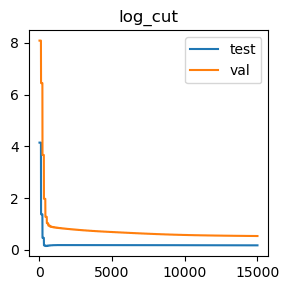

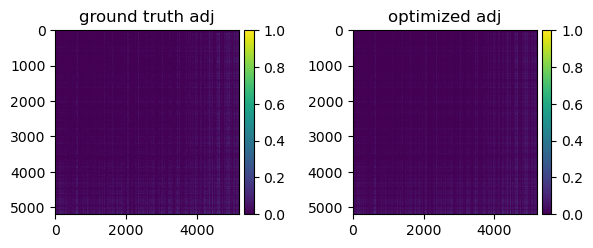



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:418:::  


FINISHED train 
 last accuracies:
test
key='log_cut': 0.17542469056762883
val
key='l2': 0.5351250171661377


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:432:::  





/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-19 07:10:43 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:372:::  
fit wrapper fit_feats, plotting state at iter 14999


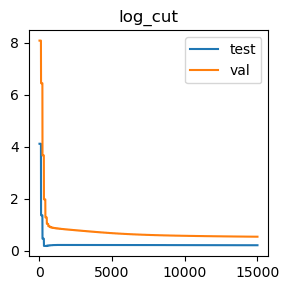

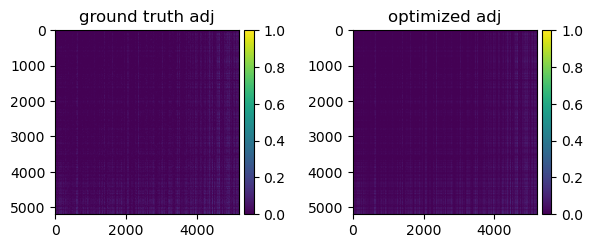



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:418:::  


FINISHED train 
 last accuracies:
test
key='log_cut': 0.20613592327637786
val
key='l2': 0.534383237361908


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:432:::  





In [ ]:
'''Experiment: Find the best d. since the log cut distance is defined by the minimal d, we look to see which d gives the minimal value. In any case, the true log cut distance will always be smaller than what is calculated.'''

import os


model_name='iegam'
ds_name = 'squirrel'



ds = import_dataset(ds_name)


# SBM
config_triplets = [
                    ['feat_opt', 'n_iter', 15000],
                    # ['feat_opt', 'lr', 0.00005],
                    # ['prior_opt', 'n_iter', 1500],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 30],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]

for d in [0.05, 0.01, 0.005]:
    trainer = Trainer(
                model_name=model_name,
                task='distance',
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=ds.clone()
    )
    # i want to optimize the trainer
    log_likelihoods, test_accs, val_accs = trainer.train(
        d=d,
        plot_every=-1,
        init_feats=True,
        init_type='small_gaus',
        verbose=False,
        acc_every=100,
        verbose_in_funcs=False
    )

    log_likelihoods = np.array(log_likelihoods)/(ds.num_nodes**2)


    dir_path = f'results/distance/find_d/squirrel/iegam/d_{d}'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    torch.save(test_accs['log_cut'], dir_path + f'/logcuts')
    torch.save(log_likelihoods, dir_path + f'/log_likelihoods')
    torch.save(val_accs['l2'], dir_path + f'/l2s')
    
    del trainer.data
    if trainer.clamiter.prior is not None:
        del trainer.clamiter.prior.model
    

#todo: make one run for 50000 iteration and see if the log cut converges.



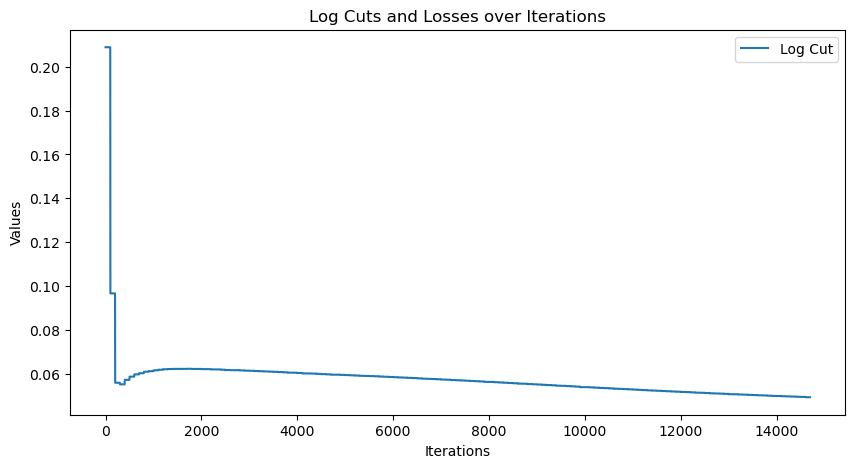

In [92]:
plot_distance_experiment(0.01, 'find_d', ds_name='squirrel', range=300)



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-19 16:21:46 starting optimization of iegam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 64,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 25000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:372:::  
fit wrapper fit_feats, plotting state at iter 24999


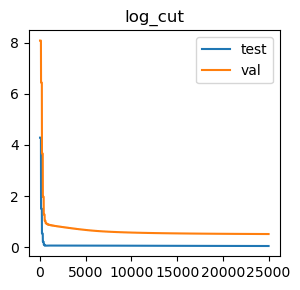

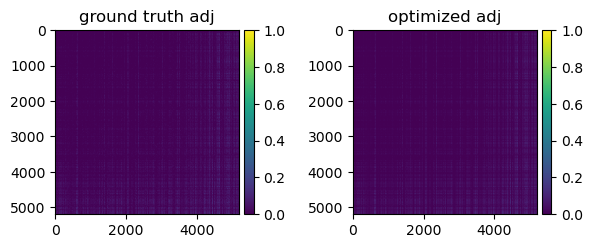



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:418:::  


FINISHED train 
 last accuracies:
test
key='log_cut': 0.04301538931748295
val
key='l2': 0.5116679072380066


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:432:::  





In [103]:
'''Experiment: try and get overfitting in the log cut distance. If we train the model for long enough, we expect that the log cut will start increasing because of overfitting so we are training it for a very long time.'''
from datetime import datetime

d = 0.01
n_iter = 25000
config_triplets = [
                    ['feat_opt', 'n_iter', n_iter],
                    # ['feat_opt', 'lr', 0.00005],
                    # ['prior_opt', 'n_iter', 1500],
                    # ['prior_opt', 'lr', 0.0000005],
                    # ['back_forth','n_back_forth', 30],
                    # ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]

trainer = Trainer(
            model_name=model_name,
            task='distance',
            device=device,
            config_triplets_to_change=config_triplets,
            dataset=ds.clone()
)
# i want to optimize the trainer
try:
    log_likelihoods, test_accs, val_accs = trainer.train(
        d=d,
        plot_every=-1,
        init_feats=True,
        init_type='small_gaus',
        verbose=False,
        acc_every=100,
        verbose_in_funcs=False
    )

    log_likelihoods = np.array(log_likelihoods)/(ds.num_nodes**2)
except Exception as e:
    raise

finally:
    dir_path = f'results/distance/train_to_overfit/squirrel/iegam/d_{d}/n_iter_{n_iter}/{datetime.now().strftime("%Y-%m-%d_%H-%M")}'
    
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    torch.save(test_accs['log_cut'], dir_path + f'/logcuts')
    torch.save(log_likelihoods, dir_path + f'/log_likelihoods')
    torch.save(val_accs['l2'], dir_path + f'/l2s')

    del trainer.data
    if trainer.clamiter.prior is not None:
        del trainer.clamiter.prior.model


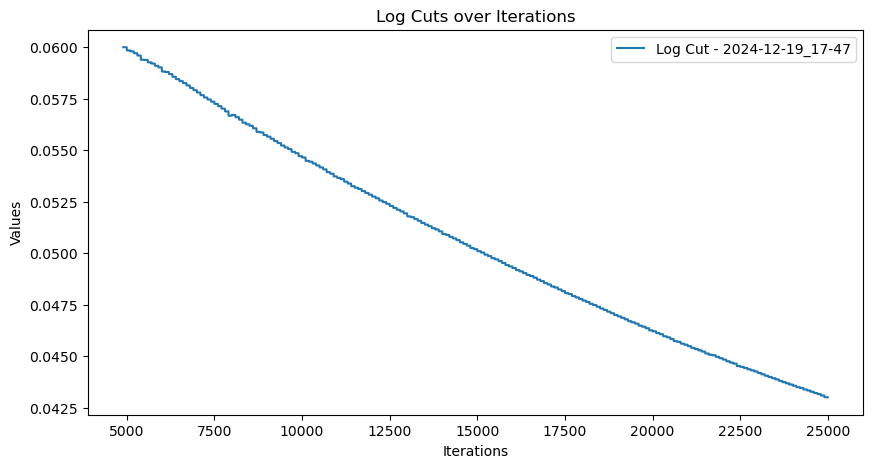

In [141]:
plot_distance_experiment(0.01, 'train_to_overfit', 'squirrel', 'iegam', 4900)

#? experimental insight: the approximation matrix reaches values of 1 via the log likelihood optimization in which case the log cut is infinity. so the limitation is also via the step size...

In [ ]:
'''Experiment: for every dataset we used find the best d and see that the log cut converges.'''

import os
import numpy as np



for ds_name in ['squirrel']:
    for model_name in ['bigclam']:
        ds = import_dataset(ds_name)


        # SBM
        config_triplets = [
                            ['feat_opt', 'n_iter', 15000],
                            # ['feat_opt', 'lr', 0.00005],
                            # ['prior_opt', 'n_iter', 1500],
                            # ['prior_opt', 'lr', 0.0000005],
                            # ['back_forth','n_back_forth', 30],
                            # ['back_forth', 'first_func_in_fit', 'feat_opt']
                        ]

        for d in [0.05, 0.01, 0.005]:
            trainer = Trainer(
                        model_name=model_name,
                        task='distance',
                        device=device,
                        config_triplets_to_change=config_triplets,
                        dataset=ds.clone()
            )
            # i want to optimize the trainer
            log_likelihoods, test_accs, val_accs = trainer.train(
                d=d,
                plot_every=-1,
                init_feats=True,
                init_type='small_gaus',
                verbose=False,
                acc_every=100,
                verbose_in_funcs=False
            )

            log_likelihoods = np.array(log_likelihoods)/(ds.num_nodes**2)


            dir_path = f'results/distance/find_d/{ds_name}/{model_name}/d_{d}'
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            torch.save(test_accs['log_cut'], dir_path + f'/logcuts')
            torch.save(log_likelihoods, dir_path + f'/log_likelihoods')
            torch.save(val_accs['l2'], dir_path + f'/l2s')
            
            del trainer.data
            if trainer.clamiter.prior is not None:
                del trainer.clamiter.prior.model
            




/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:316:::  
 2024-12-22 15:59:27 starting optimization of bigclam on squirrel on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 24,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 15000,
        "early_stop": 0
    }
}
